## Imports

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime

import logging

## Read DATA

In [2]:
read_df = pd.read_csv('../data/AEP_hourly.csv',
                      index_col=[0],
                      parse_dates=[0])
read_df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


<Axes: title={'center': 'Energy Consumed Hourly'}, xlabel='Time', ylabel='Energy'>

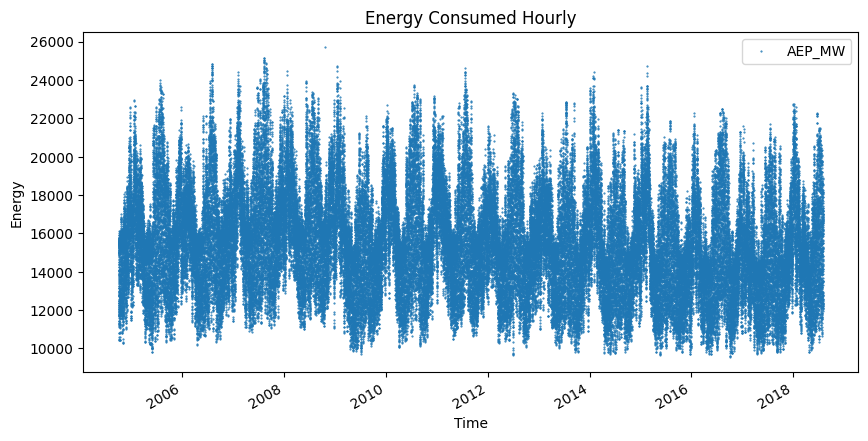

In [3]:
color_pal = sns.color_palette()
read_df.plot(
    style='.',
    figsize=(10,5),
    ms= 1,
    color = color_pal[0],
    xlabel='Time',
    ylabel='Energy',
    title='Energy Consumed Hourly'
)

# EDA

 ## Time Series Features

In [8]:
from pandas.api.types import CategoricalDtype

In [9]:
def create_features(df, label = None):
    '''
    Create time series features from datetime index
    '''

    cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df['date'].dt.month*100 + df['date'].dt.day - 320)%1300
        # create a variable  MMDD that goes from 0101 to 1231 and where we
        # have added an offset to start in winter
    df['season'] = pd.cut(
        df['date_offset'],
        [0, 300, 602, 900, 1300],
        labels = ['Spring', 'Summer', 'Fall', 'Winter']
    )

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    
    if label:
        y = df[label]
        return X,y
    return X

In [13]:
X, y = create_features(read_df, label='AEP_MW')
features_and_target = pd.concat([X,y], axis = 1)

In [14]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekday,season,AEP_MW
Datetime,,,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,Friday,Winter,13478.0
2004-12-31 02:00:00,2,4,4,12,2004,366,31,Friday,Winter,12865.0
2004-12-31 03:00:00,3,4,4,12,2004,366,31,Friday,Winter,12577.0
2004-12-31 04:00:00,4,4,4,12,2004,366,31,Friday,Winter,12517.0
2004-12-31 05:00:00,5,4,4,12,2004,366,31,Friday,Winter,12670.0


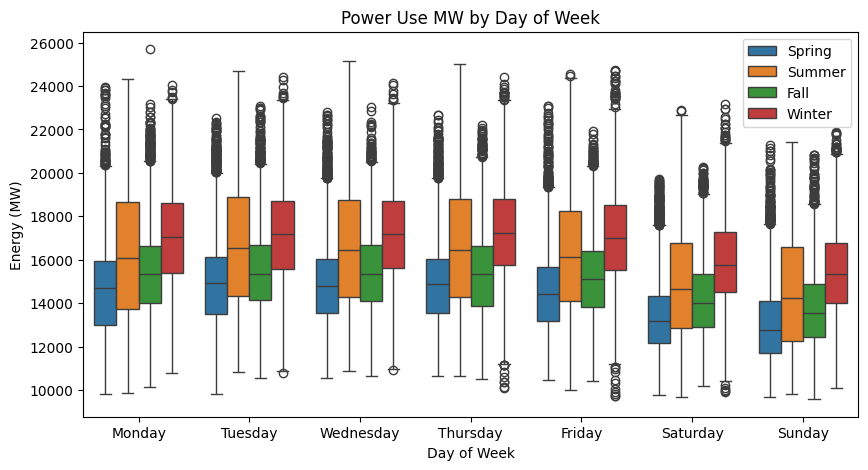

In [16]:
fig, ax = plt.subplots(
    figsize = (10,5)
)
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='AEP_MW',
            hue='season',#color
            ax=ax,
            linewidth=1
            )
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Model

## Train / Test Split

In [17]:
split_date = '1-Jan-2015'
train_df = read_df.loc[read_df.index <= split_date].copy()
test_df = read_df.loc[read_df.index > split_date].copy()

<function matplotlib.pyplot.show(close=None, block=None)>

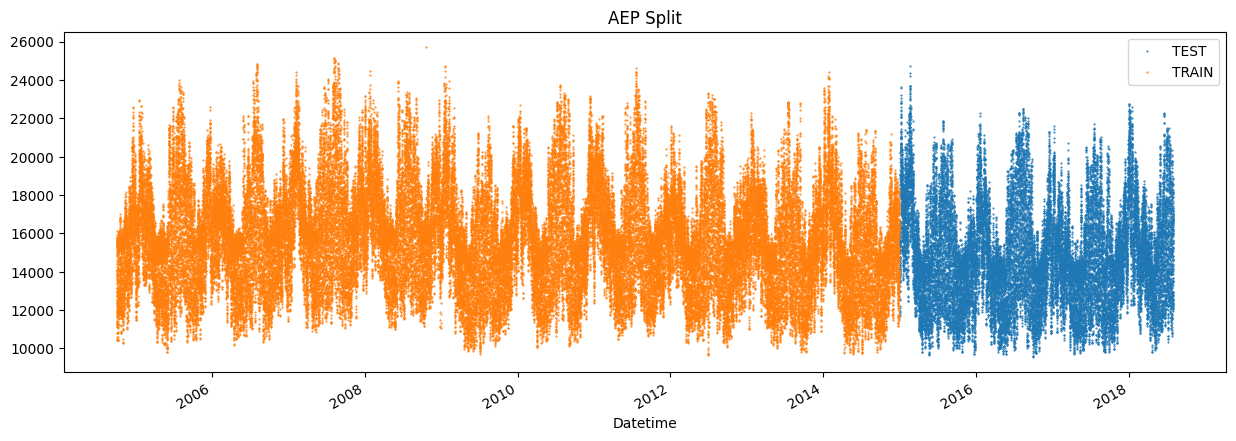

In [19]:

test_df \
    .rename(columns={'AEP_MW': 'TEST'}) \
    .join(train_df.rename(columns={'AEP_MW': 'TRAIN'}),
          how='outer')\
    .plot(figsize=(15,5), title= 'AEP Split', style='.', ms='1')
plt.show

## Simple Prophet Model
Prophet model expects the dataset to be named a specific way:
- Datetime column named: ds
- Target: y

In [20]:
train_prophet_df = train_df.reset_index()\
    .rename(columns={'Datetime': 'ds',
                     'AEP_MW': 'y'})

In [22]:
%%time
model = Prophet()
model.fit(train_prophet_df)

09:38:37 - cmdstanpy - INFO - Chain [1] start processing
09:39:31 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 7.05 s
Wall time: 1min 1s


In [23]:
test_prophet_df = test_df.reset_index() \
            .rename(columns={'Datetime':'ds',
                             'AEP_MW':'y'})

In [24]:
test_fcst_df = model.predict(test_prophet_df)

In [25]:
test_fcst_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,15029.317549,12758.805265,16647.992485,15029.317549,15029.317549,-329.965032,-329.965032,-329.965032,-1526.622373,...,601.310821,601.310821,601.310821,595.346520,595.346520,595.346520,0.0,0.0,0.0,14699.352518
1,2015-01-01 02:00:00,15029.302810,12031.624624,16013.227041,15029.302810,15029.302810,-924.673187,-924.673187,-924.673187,-2123.364850,...,602.298118,602.298118,602.298118,596.393545,596.393545,596.393545,0.0,0.0,0.0,14104.629623
2,2015-01-01 03:00:00,15029.288070,11688.000673,15773.226261,15029.288070,15029.288070,-1265.864954,-1265.864954,-1265.864954,-2465.932003,...,602.599014,602.599014,602.599014,597.468035,597.468035,597.468035,0.0,0.0,0.0,13763.423116
3,2015-01-01 04:00:00,15029.273331,11838.189367,15604.040351,15029.273331,15029.273331,-1304.109177,-1304.109177,-1304.109177,-2504.899417,...,602.220254,602.220254,602.220254,598.569985,598.569985,598.569985,0.0,0.0,0.0,13725.164154
4,2015-01-01 05:00:00,15029.258591,12111.569620,16003.099107,15029.258591,15029.258591,-1007.260835,-1007.260835,-1007.260835,-2208.136844,...,601.176617,601.176617,601.176617,599.699392,599.699392,599.699392,0.0,0.0,0.0,14021.997756


d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


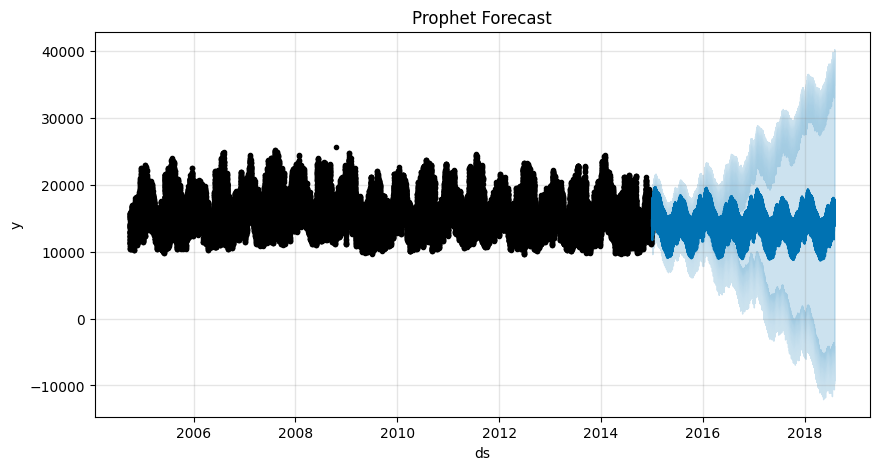

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_fcst_df, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

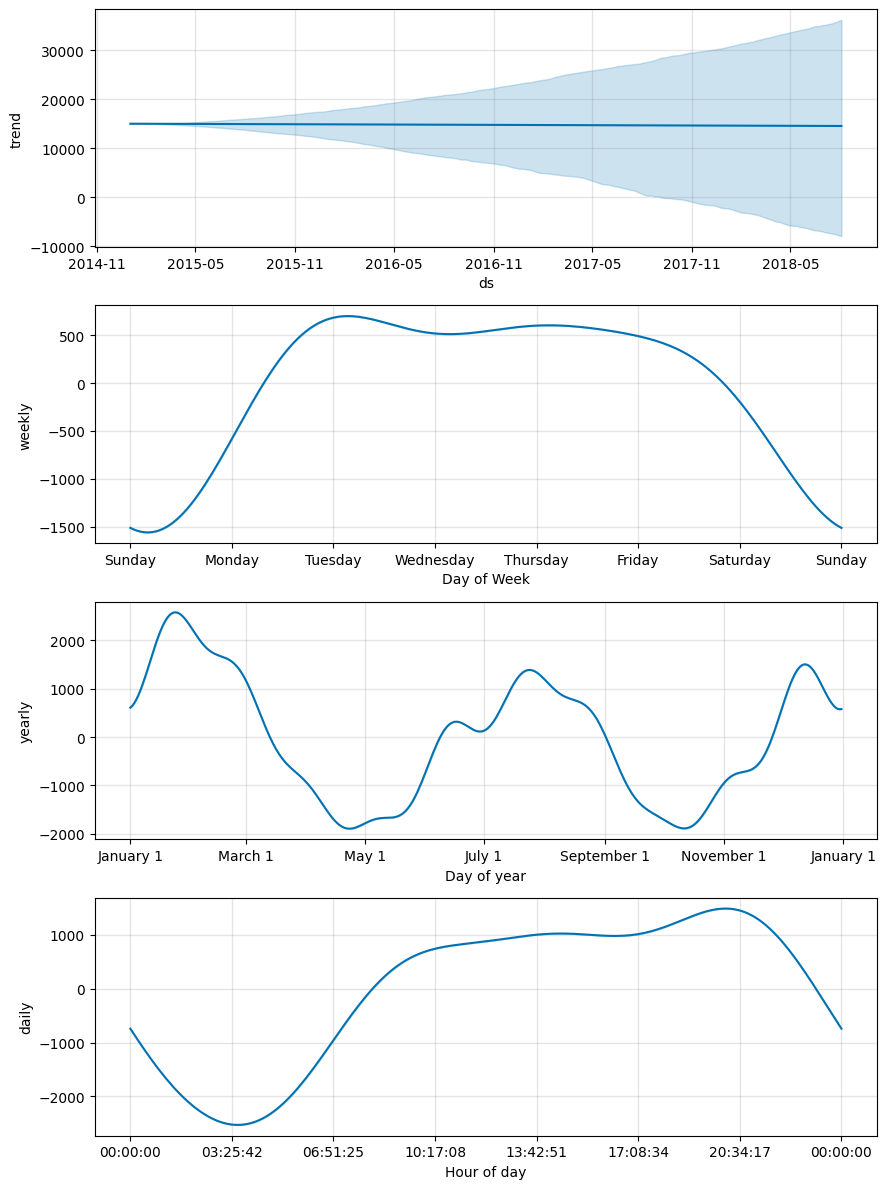

In [30]:
fig = model.plot_components(test_fcst_df)
plt.show()

# Evaluation

## Visual Comparison

d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


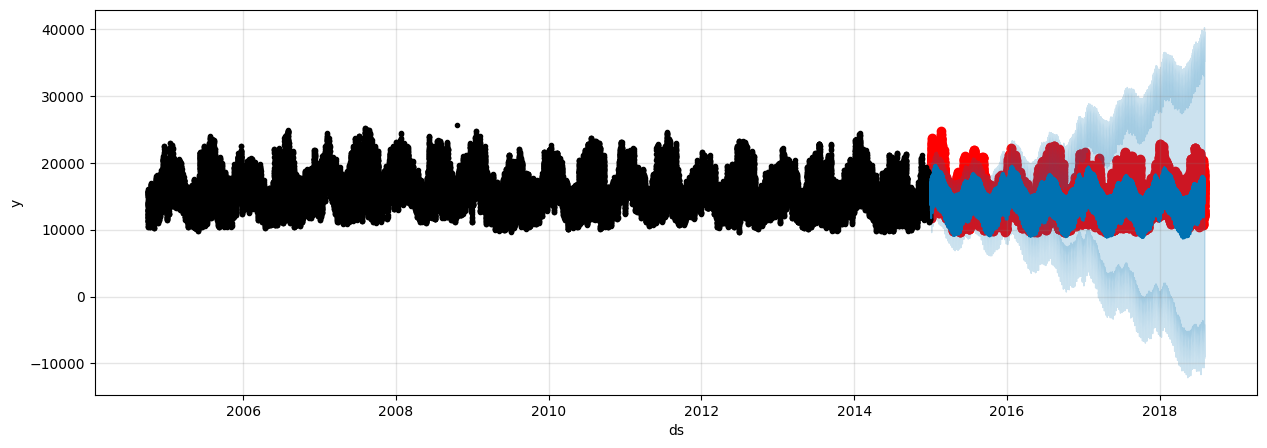

In [32]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test_df.index, test_df['AEP_MW'], color='r')
fig = model.plot(test_fcst_df, ax=ax)

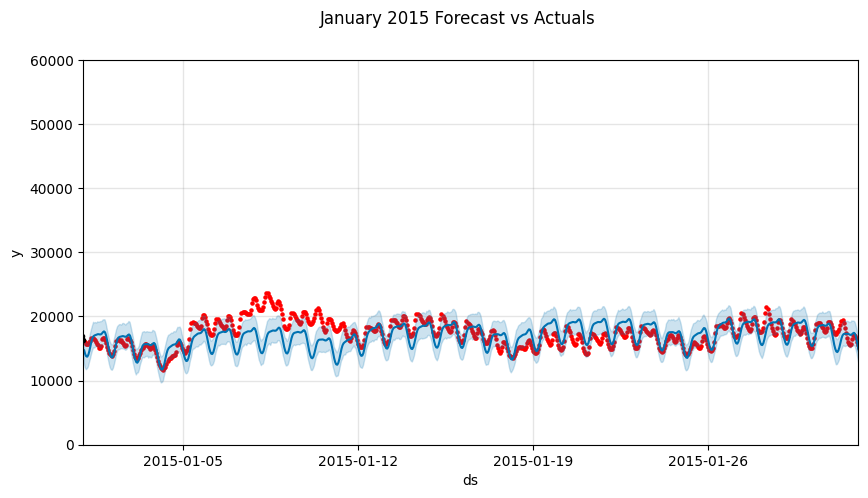

In [38]:
start_date = datetime.datetime.strptime('01-01-2015', '%m-%d-%Y')
end_date = datetime.datetime.strptime('02-01-2015', '%m-%d-%Y')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(test_df.index, test_df['AEP_MW'], color='r', s=5)
fig = model.plot(test_fcst_df, ax=ax)
ax.set_xbound(lower=start_date,
              upper=end_date)
ax.set_ylim(0,60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

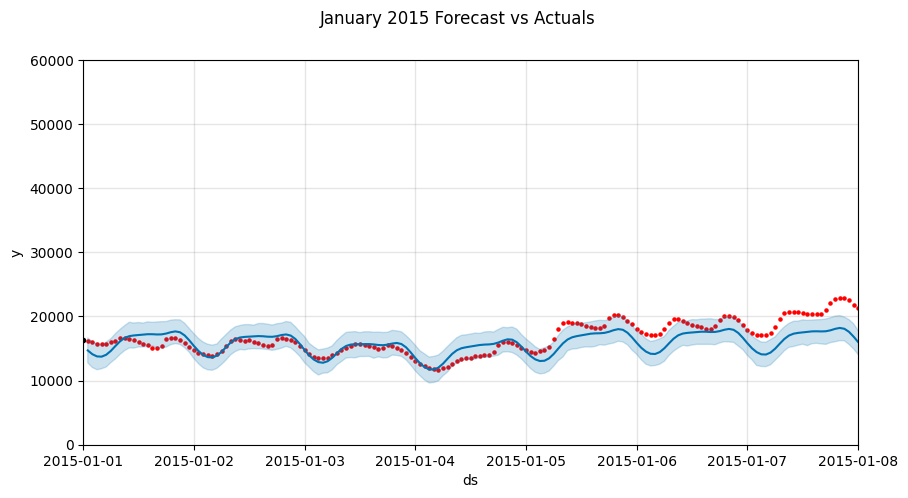

In [40]:
start_date = datetime.datetime.strptime('01-01-2015', '%m-%d-%Y')
end_date = datetime.datetime.strptime('01-08-2015', '%m-%d-%Y')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(test_df.index, test_df['AEP_MW'], color='r', s=5)
fig = model.plot(test_fcst_df, ax=ax)
ax.set_xbound(lower=start_date,
              upper=end_date)
ax.set_ylim(0,60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

## Error Metrics

In [41]:
np.sqrt(mean_squared_error(y_true=test_df['AEP_MW'],
                            y_pred=test_fcst_df['yhat']))

2602.4055566262878

In [42]:
mean_absolute_error(y_true=test_df['AEP_MW'],
                    y_pred=test_fcst_df['yhat'])

2080.9465315480884

In [48]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(
        np.absolute(
            np.subtract(y_true, y_pred) / y_true
        )
    ) *100

In [49]:
mean_absolute_percentage_error(y_true = test_df['AEP_MW'],
                               y_pred= test_fcst_df['yhat'])

14.186254300069114

# Enhance the Model

## Adding Holidays

In [50]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [65]:
cal = calendar()

holidays = cal.holidays(start=read_df.index.min(),
                        end=read_df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data = holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [66]:
holiday_df.head()

,ds,holiday
0,2004-10-11,Columbus Day
1,2004-11-11,Veterans Day
2,2004-11-25,Thanksgiving Day
3,2004-12-24,Christmas Day
4,2004-12-31,New Year's Day


In [68]:
%%time
model_holidays = Prophet(holidays=holiday_df)
model_holidays.fit(train_prophet_df)

11:12:13 - cmdstanpy - INFO - Chain [1] start processing
11:13:38 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 8.22 s
Wall time: 1min 32s


In [69]:
test_fcst_holidays_df = model_holidays.predict(test_prophet_df)

d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

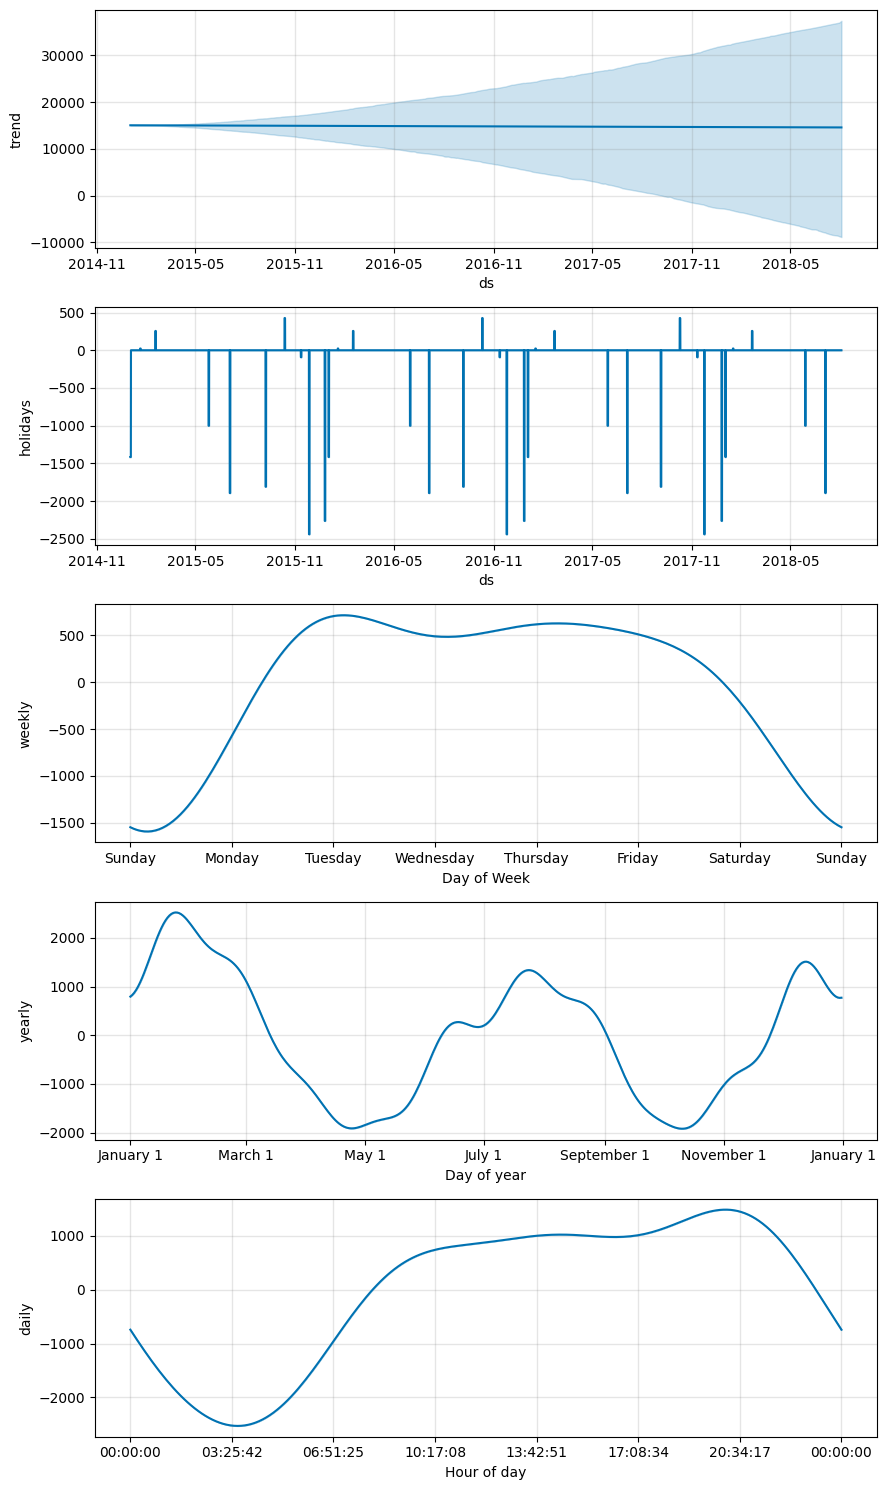

In [71]:
fig = model_holidays.plot_components(test_fcst_holidays_df)

d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Programacion\Personal\forecasting_prophet\env\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


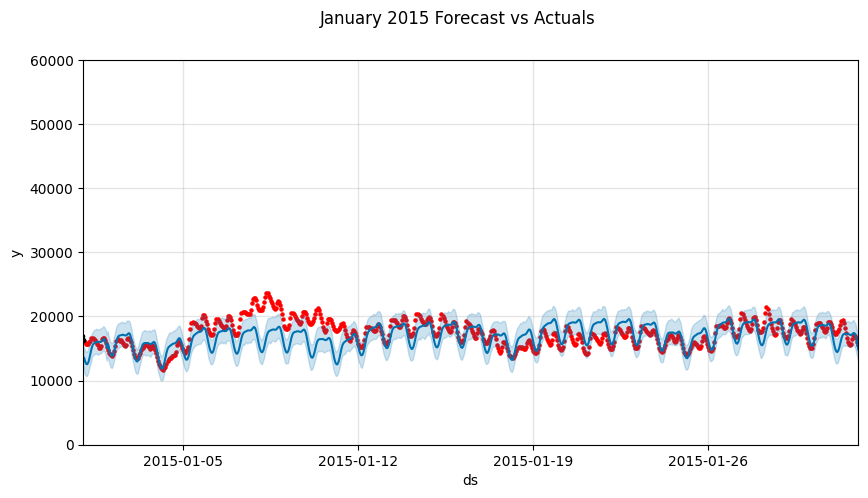

In [72]:
start_date = datetime.datetime.strptime('01-01-2015', '%m-%d-%Y')
end_date = datetime.datetime.strptime('02-01-2015', '%m-%d-%Y')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(test_df.index, test_df['AEP_MW'], color='r', s=5)
fig = model_holidays.plot(test_fcst_holidays_df, ax=ax)
ax.set_xbound(lower=start_date,
              upper=end_date)
ax.set_ylim(0,60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

## Error Metrics

In [73]:
np.sqrt(mean_squared_error(y_true=test_df['AEP_MW'],
                            y_pred=test_fcst_holidays_df['yhat']))

2620.4584631095545

In [76]:
mean_absolute_error(y_true=test_df['AEP_MW'],
                    y_pred=test_fcst_holidays_df['yhat'])

2094.581832616438

In [79]:
mean_absolute_percentage_error(y_true = test_df['AEP_MW'],
                               y_pred= test_fcst_holidays_df['yhat'])

14.28074363404494

# Predict into the Future

In [ ]:
model.make_future_dataframe(periods=365*24, freq='h', include_history=False)